In [72]:
import gzip
import json
import re
import os
import sys
import timeit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import sklearn.manifold
import tensorflow as tf
import altair as alt
import collections


from src.load_data import read_tables
from src.CFModel import CFModel, build_CF_model, compute_scores, book_neighbors, user_recommendations
from src.Baseline_Model import build_baseline_model

### load data

In [37]:
# data from Goodreads: reviews and meta data on mystery_thrill_crime books filtered to keep english only books

reviews = pd.read_csv('data/cleaned_reviews_mystery_1.csv')
books = pd.read_csv('data/cleaned_books_mystery_1.csv')

In [97]:
print('num of books is %d \nnum of users is %d'%(reviews.book_id.nunique(), reviews.user_id.nunique()))

num of books is 105365 
num of users is 121333


## Models

initially we wanted to use evaluation score: the mean of each user's top 5 recommended books' actual rating

since 85% of the users in test data only have 1 ratings, the evaluation score is almost the same (3.865) no matter recommendations are based on which model. (will delete the score later)

we will use mse as evaluation score considering our dataset is sparse

### baseline model - global mean adjusted by user/book deviation

baseline estimate for r_xi = u + b_x + b_i

u: global mean (overall mean book ratings)

b_x: rating deviation of user x = (avg. rating of user x) - u

b_i: rating deviation of book i = (avg. rating of book i) - u

In [40]:
train_mse_error, test_mse_error, test_rmse_error, test_mae_error, evaluation_score = build_baseline_model(reviews) 
#print out train dataset mean rating to confirm each model uses the same training data

train_data mean rating: 3.80621


/Users/elainewu/Documents/Projects/Assignments/Capstone/Capstone Three/Goodreads_Book_Recommender/src/Baseline_Model.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['prediction'] = np.zeros(len(reviews))


train mse: 15.53125 
 test_mse: 15.97210, test_rmse: 3.99651, test_mae: 3.86546, 
 evaluation_score: 3.86546


#### always recommend the most popular books

In [105]:
#the books with most reviews in our dataset, which the model will learn these books best
pop_book = reviews.book_id.value_counts()[:10]
pop_book

44449     11373
98973      7906
50968      5698
22647      4054
24807      3997
36873      3970
86372      3806
104081     3346
84502      3292
90886      3103
Name: book_id, dtype: int64

In [112]:
pop_book_dict = {}
for i in list(pop_book.index):
    pop_book_dict[i] = books[books.book_id == i].title.iloc[0]
pop_book_dict    

{44449: 'The Girl on the Train',
 98973: 'Gone Girl',
 50968: 'The Girl with the Dragon Tattoo (Millennium, #1)',
 22647: "The Cuckoo's Calling (Cormoran Strike, #1)",
 24807: 'Inferno (Robert Langdon, #4)',
 36873: 'Big Little Lies',
 86372: 'Dark Places',
 104081: 'The Da Vinci Code (Robert Langdon, #2)',
 84502: 'The Girl Who Played with Fire (Millennium, #2)',
 90886: 'Sharp Objects'}

In [140]:
# the most popular books per book meta data
books.sort_values('ratings_count', ascending=False)[:11]

,book_id,title,num_pages,is_ebook,link,average_rating,ratings_count,text_reviews_count,author_id,publisher,similar_books,old_book_id,x
98519,103712,"Angels & Demons (Robert Langdon, #1)",736,0,https://www.goodreads.com/book/show/960.Angels...,3.86,2046499,19683,630,Pocket Books,"['15769', '92147', '1178039', '4312852', '4170...",960,nan
57299,50968,"The Girl with the Dragon Tattoo (Millennium, #1)",465,0,https://www.goodreads.com/book/show/2429135.Th...,4.11,1858152,48632,706255,Knopf,"['3522419', '359126', '39792', '1437993', '714...",2429135,nan
98520,104081,"The Da Vinci Code (Robert Langdon, #2)",481,0,https://www.goodreads.com/book/show/968.The_Da...,3.79,1465770,33535,630,Anchor,"['573202', '1178039', '278210', '198331', '658...",968,nan
87767,44449,The Girl on the Train,323,0,https://www.goodreads.com/book/show/22557272-t...,3.88,1076144,78438,1063732,Riverhead Books,"['2302650', '22535503', '22693182', '20821043'...",22557272,nan
70701,73559,A Time to Kill,515,0,https://www.goodreads.com/book/show/32542.A_Ti...,4.03,604739,3691,721,Delta,"['13148', '15159', '19691', '107483', '4035', ...",32542,nan
80113,36356,Gone Girl,415,0,https://www.goodreads.com/book/show/19288043-g...,4.03,588451,21082,2383,Broadway Books,"['12598982', '13096307', '7093952', '11367726'...",19288043,nan
1584,84502,"The Girl Who Played with Fire (Millennium, #2)",503,0,https://www.goodreads.com/book/show/5060378-th...,4.22,575163,24868,706255,Alfred A. Knopf,"['39801', '13057652', '6304285', '3322382', '1...",5060378,nan
51720,98973,Gone Girl,399,0,https://www.goodreads.com/book/show/8442457-go...,4.03,513361,69096,2383,Weidenfeld & Nicolson,"['12598982', '13096307', '7093952', '11367726'...",8442457,nan
60331,85187,"The Firm (Penguin Readers, Level 5)",75,0,https://www.goodreads.com/book/show/5358.The_Firm,3.99,494812,3173,608211,Addison Wesley Publishing Company,"['425029', '98427', '481372', '32682', '2430',...",5358,nan
73260,104387,Deception Point,556,0,https://www.goodreads.com/book/show/976.Decept...,3.67,464544,6394,630,Pocket Books,"['294047', '5369', '647609', '113138', '19688'...",976,nan


### CF model with adam optimizer

In [41]:
# matrix factorization without regularization with adam optimizer
# adam optimizer -> adaptive moment estimation with changing learning rate 
# https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

model_adam = build_CF_model(reviews, embedding_dim=30, init_stddev=0.05)

train_data mean rating: 3.80621


 iteration 600: train_error=0.10991632, regularization_error=0.0, test_mse_loss=17.602262, test_rmse_loss=4.195505, test_mae_loss=(3.4263697, 3.426105)92))

[{'train_error': 0.10991632,
  'regularization_error': 0.0,
  'test_mse_loss': 17.602262,
  'test_rmse_loss': 4.195505,
  'test_mae_loss': (3.4263697, 3.426105)}]

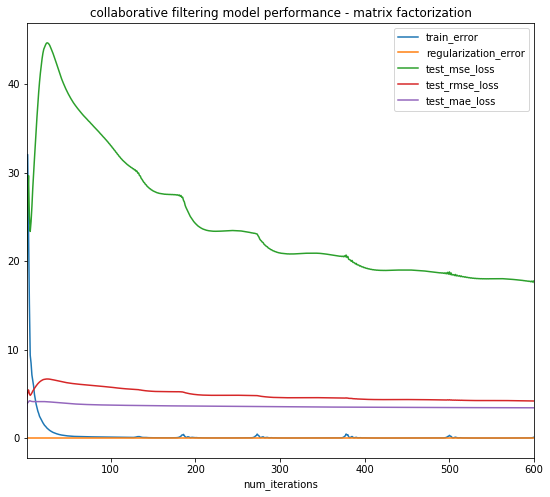

In [42]:
model_adam.train(num_iterations=600)

### CF model with regularization and adam optimizer

In [43]:
# A CFModel object that uses a regularized loss with adam optimizer
model_reg = build_CF_model(reviews, embedding_dim=30, init_stddev=0.05, 
                    regularization_coeff=0.1)

train_data mean rating: 3.80621


 iteration 50: train_error=0.89110804, regularization_error=0.7517921, test_mse_loss=6.2241125, test_rmse_loss=2.494817, test_mae_loss=(2.503087, 2.4920325)))

[{'train_error': 0.89110804,
  'regularization_error': 0.7517921,
  'test_mse_loss': 6.2241125,
  'test_rmse_loss': 2.494817,
  'test_mae_loss': (2.503087, 2.4920325)}]

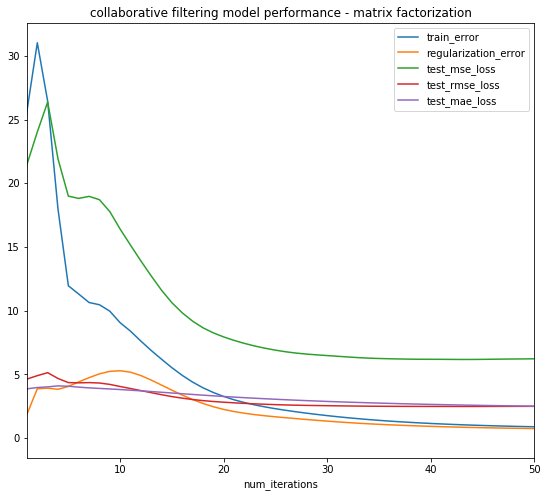

In [44]:
start_time = timeit.default_timer()
model_reg.train(num_iterations=50)

print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

#### evaluation score is calculated based on  the mean of the top 5% recommended books' actual ratings

since 85% of the users in test data only have 1 ratings, the evaluation score is almost the same (3.865) no matter recommendations are based on which model. (will delete the score later)

In [47]:
# eval_score(test_ratings, model_reg.embeddings['user_id'], model_reg.embeddings['book_id'] )

In [50]:
# 85% of the users in test data only have 1 ratings
# (test_ratings.user_id.value_counts() >1).sum()/len(test_ratings)

In [51]:
# save model_embeddings
np.savez('model/model_reg_embeddings.npz', model_reg.embeddings['user_id'], model_reg.embeddings['book_id'])

In [52]:
# load model_embeddings

# file = np.load('model/model_reg_embeddings.npz')
# user_embeddings = file['arr_0']
# book_embeddings = file['arr_1']

### Explore model_reg performance

#### get recommendations for a given user

In [53]:
#example with user 'd889b42d9eb7b80e02f24830e27c6389'
user_id = 'fca26c34be8fe623ee340061f1281796'
sample_user_pred = user_recommendations(books, reviews, model_reg, user_id, measure='cosine', k=6)

The highest recommendations for user fca26c34be8fe623ee340061f1281796.


In [54]:
sample_user_pred.sort_values('cosine score', ascending=False)[:5]

,cosine score,titles,is_ebook,average_rating,ratings_count,text_reviews_count
2755,0.9243437647819519,Justification for Murder (The Darcy Lynch Seri...,1,3.96,532,49
95336,0.9202973246574402,The Fate of Katherine Carr,0,3.23,42,12
21646,0.9196286201477051,Oblivion,0,3.83,994,177
27913,0.9194287657737732,The Fear Index,0,3.41,122,27
56044,0.9175232648849487,Sweet Reason,0,3.43,7,4


In [55]:
# explore the user_prediction (TODO: to delete later)


sample_user_pred = sample_user_pred.reset_index()

sample_user_pred.head()
sample_user_pred.columns = ['old_book_id', 'cosine score', 'titles', 'is_ebook', 'average_rating', 'ratings_count', 'text_reviews_count']

sample_user_actual = reviews[reviews.old_user_id == 'fca26c34be8fe623ee340061f1281796']

for_sample_user_model = sample_user_pred.merge(sample_user_actual, how='left', left_on='old_book_id', right_on = 'old_book_id')

user_df = reviews.groupby('old_user_id').count()['rating']
user_df.head()


old_user_id
00009e46d18f223a82b22da38586b605    15
0000c3d51aa099745e93a4e99c4856c8     4
000192962b87d560f00b06fdcbd71681     2
000253cf1077f203bca050637f2ec7f7     6
00048fe3297cbb92a6e9fb78a6dce421     2
Name: rating, dtype: int64

In [56]:
(user_df.sort_values(ascending=False) > 30).sum()/len(user_df)

0.08478319995384603

### get neighbors of a book which contains a given substring

In [126]:
# use 'The Da Vinci Code' as an example to explore
# the features 'similar_books' means Goodreads members who liked current book also liked
books[books.book_id == 104081].similar_books.iloc[0]

"['573202', '1178039', '278210', '198331', '6588', '14554', '144791', '294046', '39031', '78971', '5053', '85319', '5355', '238142', '33808']"

In [130]:
similar_book_by_gr = ['573202', '1178039', '278210', '198331', '6588', '14554', '144791', 
                      '294046', '39031', '78971', '5053', '85319', '5355', '238142', '33808']
books[books.old_book_id.isin(similar_book_by_gr)].title

87907         The Venetian Betrayal (Cotton Malone, #3)
17719           Seven Deadly Wonders (Jack West Jr, #1)
60762      If Tomorrow Comes (Tracy Whitney Series, #1)
99372                  Valhalla Rising (Dirk Pitt, #16)
21047                  Visions in Death (In Death, #19)
32828     The Expected One (Magdalene Line Trilogy, #1)
63783                The Judas Strain (Sigma Force, #4)
102348                 The Lion's Game (John Corey, #2)
11717       The Cabinet of Curiosities (Pendergast, #3)
79095                       The Man From St. Petersburg
60325                                       The Chamber
46538              The Matarese Countdown (Matarese #2)
87083                The Big Bad Wolf  (Alex Cross, #9)
82699                                  False Impression
49066                                  The Millionaires
Name: title, dtype: object

In [114]:
title_substring ='Da Vinci'
book_neighbors(books, reviews, model_reg, title_substring, measure='cosine', k=10)

Nearest neighbors of : The Da Vinci Code (Robert Langdon, #2).
[Found more than one matching book. Other candidates: The Da Vinci Code (Robert Langdon, #2), The Da Vinci Code (Robert Langdon, #2), The Da Vinci Code (Robert Langdon, #2), The Da Vinci Code (Robert Langdon, #2), The Da Vinci Diamond (Detective Tony Mariani Mysteries #1), The Da Vinci Code (Robert Langdon, #2), The Da Vinci Code (Robert Langdon, #2), The Da Vinci Code (Robert Langdon, #2), The Da Vinci Legacy, The Stolen Da Vinci Manuscripts, The Da Vinci Code (Robert Langdon, #2), The Da Vinci Code (Robert Langdon, #2), The Da Vinci Code: (Robert Langdon Book 2), The Da Vinci Code, The Da Vinci Code (Robert Langdon, #2), The Da Vinci Code (Robert Langdon, #2), The Da Vinci Code (Robert Langdon, #2), The Da Vinci Code (Robert Langdon, #2), The Da Vinci Deception (Jack Oxby, #1), The Da Vinci Cook (Angie Amalfi, #14), The Da Vinci Code (Robert Langdon, #2), The Da Vinci Code (Robert Langdon, #2), The Da Vinci Code (Robert L

,cosine score,titles,is_ebook,average_rating,ratings_count
2483,0.9999999403953552,"The Da Vinci Code (Robert Langdon, #2)",0,3.79,212
12296,0.8529649376869202,Dare Me,1,3.23,825
55408,0.842140793800354,The Forgetting Time,0,3.79,8599
19164,0.8417041897773743,Vampire For Hire: The Short Stories,1,3.99,218
22858,0.8397622108459473,Black Hawk Day Rewind,0,4.4,17
47364,0.8377163410186768,"Wordless (Pink Sofa Secrets, #1)",1,4.33,16
73830,0.8342380523681641,"At Witt's End (Sadie Witt Mystery, #1)",0,3.41,33
17148,0.8330861926078796,A Price for Genius,0,5.0,4
104230,0.8315340280532837,Blowback: Adventures of a Dope Smuggler,0,3.71,66
26028,0.830925703048706,Yellow Death (Kris Jensen #1),0,4.36,25


In [152]:
# from our review data, check which books are co-rated highly with a given book
def get_top_corated(ratings, books, book_id):
    user_ids = ratings['user_id'][ratings['book_id']==book_id].unique()
    co_ratings = ratings[ratings['user_id'].isin(user_ids)]
    top_books_count = pd.DataFrame(co_ratings['book_id'].value_counts()[:10]).reset_index()
    top_books_count.columns = ['book_id', 'count']                           
    top_books_count = pd.merge(top_books_count, books[['book_id', 'title', 'average_rating']], on='book_id')
    #top_books_count['title'] = books['title']top_books_count.index
    return top_books_count

get_top_corated(reviews, books, 104081)

,book_id,count,title,average_rating
0,104081,3346,"The Da Vinci Code (Robert Langdon, #2)",3.79
1,103712,816,"Angels & Demons (Robert Langdon, #1)",3.86
2,88907,468,"The Lost Symbol (Robert Langdon, #3)",3.66
3,50968,393,"The Girl with the Dragon Tattoo (Millennium, #1)",4.11
4,24807,348,"Inferno (Robert Langdon, #4)",3.81
5,44449,330,The Girl on the Train,3.88
6,98973,251,Gone Girl,4.03
7,104387,233,Deception Point,3.67
8,4280,229,Digital Fortress,3.61
9,84502,207,"The Girl Who Played with Fire (Millennium, #2)",4.22


### inspect neighbor clustering

In [58]:
def book_embedding_norm(books, models):
    """
    visualizes the norm and number of ratings of the book
    Args:
        model: a MFmodel object
    """
    if not isinstance(models, list):
        models = [models]
    df=pd.DataFrame({
        'title': books['title'],
        'average_rating': books['average_rating'],
        'ratings_count':books['ratings_count']
    })
    charts = []
    brush = alt.selection_interval()
    for i, model in enumerate(models):
        norm_key = 'norm' +str(i)
        df[norm_key] = np.linalg.norm(model.embeddings['book_id'], axis=1) #only included the first 1000 books for visualization
        nearest = alt.selection(
                type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
                empty='none')
        base = alt.Chart().mark_circle().encode(
                x='ratings_count',
                y=norm_key,
               color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
            ).properties(selection=nearest).add_selection(brush)
        text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='ratings_count', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
        charts.append(alt.layer(base, text))
    return alt.hconcat(*charts, data=df[:1000])
    
    

In [85]:
def visualize_book_embeddings(data, x, y):
    nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
    base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(is_ebook_filter, "is_ebook", alt.value("whitesmoke")),
      ).properties(
      width=600,
      height=600,
      selection=nearest)
    text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
    return alt.hconcat(alt.layer(base, text), is_ebook_chart, data=data)


In [86]:
is_ebook_filter = alt.selection_multi(fields=['is_ebook'])
is_ebook_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('is_ebook'),
    color=alt.condition(
        is_ebook_filter,
        alt.Color("is_ebook:N"),
        alt.value('lightgray'))
).properties(height=300, selection=is_ebook_filter)

In [87]:
def tsne_book_embeddings(model_embedding, books):
    """Visualizes the book embeddings, projected using t-SNE with Cosine measure.
    Args:
    model: A MFModel object.
    """
    tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

    print('Running t-SNE...')
    V_proj = tsne.fit_transform(model_embedding)
    print(V_proj.shape, books.shape)
    books.loc[:,'x'] = V_proj[:, 0]
    books.loc[:,'y'] = V_proj[:, 1]
    return visualize_book_embeddings(books, 'x', 'y')

#### visulize book embedding

In [64]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

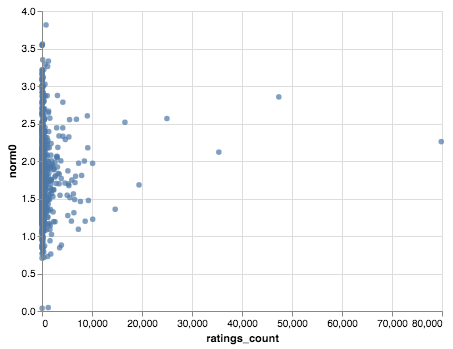

In [65]:
book_embedding_norm(books, model_reg)

#### visualize book clustering

In [82]:
books_vis = books.sort_values(by='book_id')[:5000]

In [83]:
model_book_emb_vis = model_reg.embeddings['book_id'][:5000]

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.758s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.143916
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.575378
[t-SNE] KL divergence after 400 iterations: 3.670065
(5000, 2) (5000, 13)


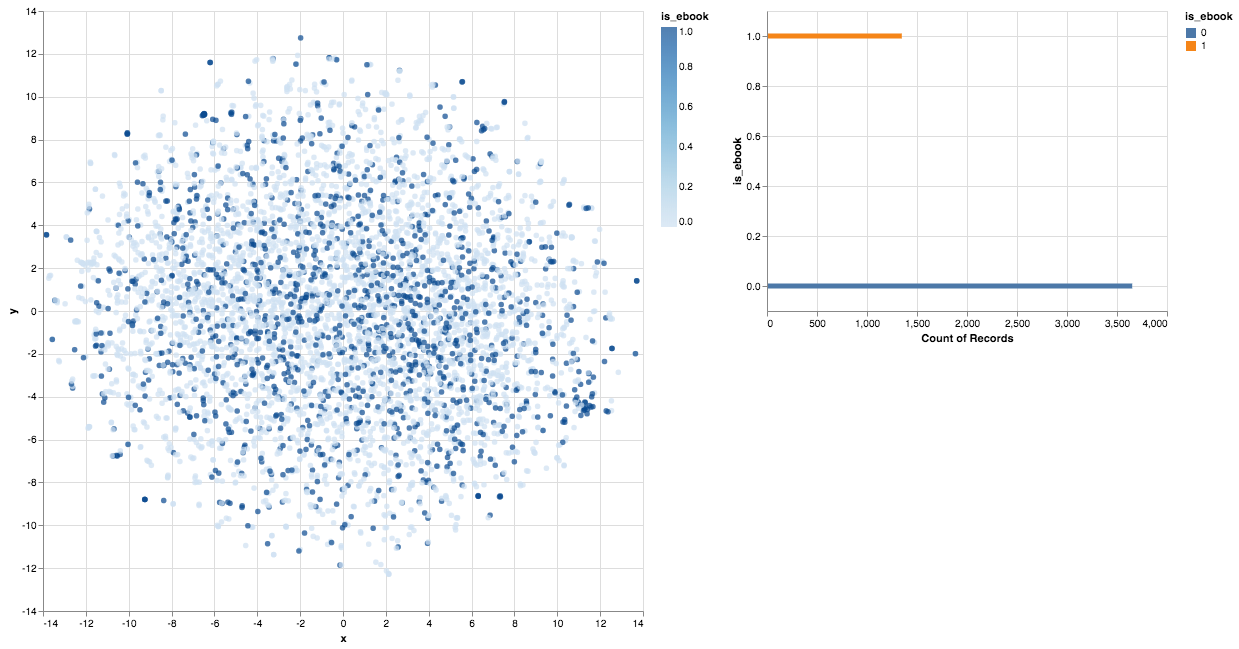

In [88]:
tsne_book_embeddings(model_book_emb_vis, books_vis)